In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'sample_submission.csv', 'train.csv', 'train']


In [2]:
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

path = '../input'
train_csv = os.path.join(path, 'train.csv')
train = pd.read_csv(train_csv)
categories = train.groupby('Id').size()

train_data, val_data =  train_test_split(train, test_size=0.1, random_state=2018)
train_data.to_csv('train.csv', index=False)
val_data.to_csv('val.csv', index=False)
print(os.listdir("../working"))

Using TensorFlow backend.


['val.csv', 'train.csv', '.ipynb_checkpoints', '__notebook_source__.ipynb']


In [3]:
# Make Categories dictionary
Id_dict = {}

for i, id in enumerate(categories.index):
    if id in Id_dict:
        continue
    Id_dict[id] = i

print('Number of categories of Whale: {}'.format(len(Id_dict)))

Number of categories of Whale: 5005


In [4]:
Img_Gen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True)


def read_images(image_name):
    
    base_size = 224
    path = '../input/train'
    image_path = os.path.join(path, image_name)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (base_size, base_size))
    img = img / 255
    
    return img

def Image_creator(image, max_num_to_create):
    
    created_image = []
    for d in Img_Gen.flow(image, batch_size=1):
        created_image.append(np.asarray(d[0]))
        
        if len(created_image) == max_num_to_create:
            break
            
    return created_image       

def generator(batch_size, target, max_num_to_create):
    while True:
        csv_file = os.path.join("../working", target+'.csv')
        for df in pd.read_csv(csv_file, chunksize=batch_size):
            X_train = []
            y_train = []
            for name in df.Image:
                img = read_images(name)
                img = img.reshape((1,)+img.shape)
                created_img = Image_creator(img, max_num_to_create)
                [X_train.append(img) for img in created_img]
            for id in df.Id:
                [y_train.append(Id_dict[id]) for _ in range(max_num_to_create)]
            X_train = np.asarray(list(X_train))
            y_train = to_categorical(y_train, num_classes=len(Id_dict))
            
            yield X_train, y_train
            

In [5]:
train_generator = generator(32, target='train', max_num_to_create=3)
X_train,y_train = next(train_generator)
print(X_train.shape)
print(y_train.shape)

(96, 224, 224, 3)
(96, 5005)


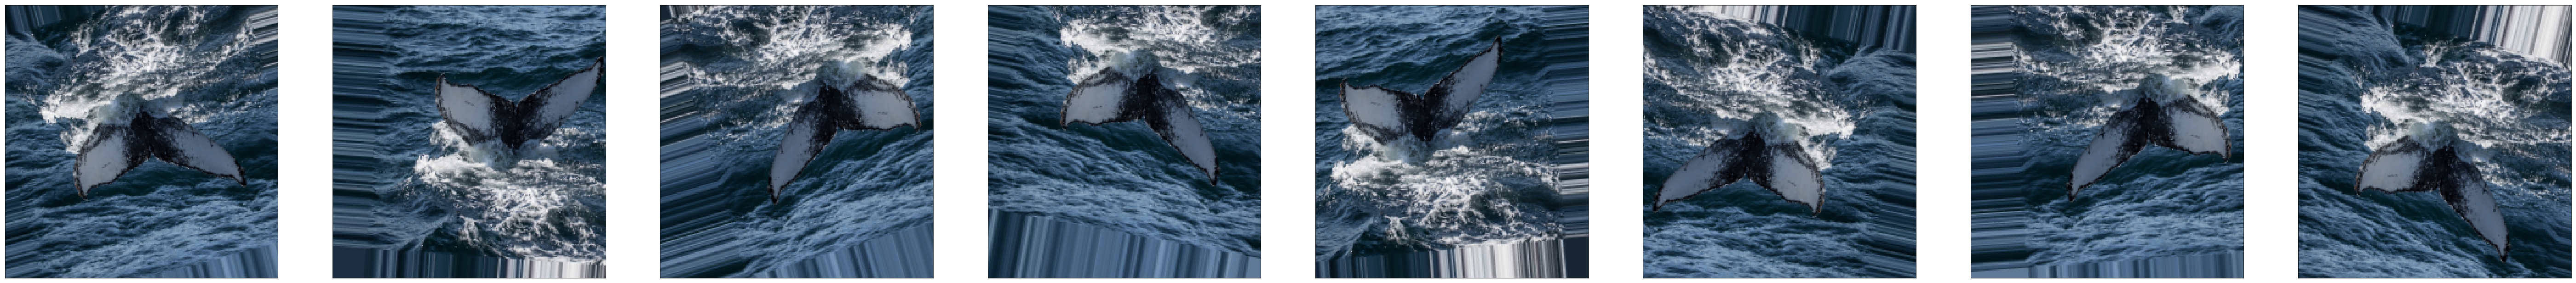

In [6]:
#For test
max_num_to_create = 8
img = read_images('0000e88ab.jpg')
#print(img.shape)
img = img.reshape((1,)+img.shape)
#print(img.shape)
created_img = Image_creator(img, max_num_to_create)
#print(len(created_img))

plt.figure(figsize=(100, 100))
for i in range(len(created_img)):
    plt.subplot(1, max_num_to_create, i+1)
    plt.imshow(cv2.cvtColor(created_img[i], cv2.COLOR_BGR2RGB))
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [7]:
val_csv = os.path.join("../working",  'val.csv')
val = pd.read_csv(val_csv)

X_test = []
y_test = []

for img_name in tqdm(val.Image):
    img = read_images(img_name)
    X_test.append(img)
    
for id in tqdm(val.Id):
    y_test.append(Id_dict[id])

X_test = np.asarray(list(X_test))
y_test = to_categorical(y_test, num_classes=len(Id_dict))

print(X_test.shape)
print(y_test.shape)

100%|██████████| 2537/2537 [00:00<00:00, 875726.22it/s]


(2537, 224, 224, 3)
(2537, 5005)


In [8]:
from keras.applications import ResNet50, MobileNetV2, MobileNet
from keras.models import Model
from keras.layers import Input, GlobalAvgPool2D, Dense, Dropout
from keras import metrics
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

def top_5_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)

input_tensor = Input(shape=(224, 224, 3))
base_model = MobileNet(input_tensor=input_tensor, include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAvgPool2D()(x)
x = Dropout(0.5)(x)
x = Dense(10010, activation='relu')(x)
predictions = Dense(5005, activation='softmax')(x)
model = Model(inputs=input_tensor, outputs=predictions)

model.compile(optimizer= optimizers.Adam(lr=0.01, decay=0.01),loss='categorical_crossentropy', 
              metrics=[metrics.categorical_accuracy, top_5_accuracy])
model.summary()

callbacks = [EarlyStopping(patience=0),ReduceLROnPlateau(patience=0)]

/opt/conda/lib/python3.6/site-packages/keras_applications/mobilenet.py:207: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [9]:
model.fit_generator(train_generator, steps_per_epoch=800, epochs=100, 
                   callbacks=callbacks, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
800/800 [==============================] - 1310s 2s/step - loss: 9.9939 - categorical_accuracy: 0.3794 - top_5_accuracy: 0.9987 - val_loss: 9.9745 - val_categorical_accuracy: 0.3812 - val_top_5_accuracy: 1.0000
Epoch 2/100
 35/800 [>.............................] - ETA: 17:25 - loss: 10.2321 - categorical_accuracy: 0.3652 - top_5_accuracy: 1.0000

KeyboardInterrupt: 

In [ ]:
test_pictures = os.listdir('../input/test')
print(test_pictures[:5])

def read_test_images(image_name):
    base_size = 224
    path = '../input/test'
    image_path = os.path.join(path, image_name)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (base_size, base_size))
    img = img / 255
    
    return img

test_images = []
for img_name in test_pictures:
    test_images.append(read_test_images(img_name))

test_images = np.asarray(test_images)
print(test_images.shape)

In [ ]:
test_images = np.expand_dims(test_images, axis=-1)
print(test_images.shape)

In [ ]:
def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :5], columns=['a', 'b', 'c', 'd', 'e'])

to_class = {}
for key, value in Id_dict.items():
    to_class[value] = key

all_top5 = pd.DataFrame()
test_predictions = model.predict(test_images, batch_size=128, verbose=1)
top5 = preds2catids(test_predictions)
all_top5 = all_top5.append(top5, ignore_index=True)
print(all_top5.head())

In [ ]:
all_top5 = all_top5.replace(to_class)
all_top5.head()

In [ ]:
predictions = all_top5['a'] + ' ' + all_top5['b'] + ' ' + all_top5['c'] + ' ' + all_top5['d'] + ' ' + all_top5['e'] 

submission = pd.DataFrame({'Image':test_pictures,
                          'Id': predictions})

submission.head()
submission.to_csv('submission.csv', index=False)

In [ ]:
print(os.listdir("../working"))